# The performance of reference matching and migration to Elasticsearch

19.03.2021 Dominika Tkaczyk

In this notebook I investigate how search-based reference matching with validation (SBMV) will be affected by the migration of REST API to Elasticsearch.

SBMV is our main reference matching approach for unstructured references. Underneath the hood, it uses REST API's `query.bibliographic` functionality to find candidates for a given reference string. It also uses the relevance scores return by the REST API's search engine to calculate the matching similarity score. Planned migration from Solr search engine to Elasticsearch (ES) might affect both the returned DOIs, their order, and scores, and in turn affect the performance of SBMV reference matching. Here I investigate how the matching will be affected.

In [1]:
import sys
sys.path.append('../..')

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import utils.data_format_keys as dfk
import pandas as pd

from utils.utils import read_json
from evaluation.link_metrics import LinkMetricsResults

DATA_DIR = 'data/'

## Matching similarity scores

In SBMV, for a given reference string, candidate DOIs are scored based on similarity between the reference string and the candidate's metadata. Those scores are normalized to be in the range 0-1. Then the final decision whether to return the best match is made based on the predefined threshold. This threshold is the most important parameter of the matching.

Validation dataset is composed of 1000 reference strings and is used to find the best score threshold. The best threshold is the threshold, for which [F1 evaluation metric](https://en.wikipedia.org/wiki/F-score) calculated on the validation dataset is the highest. F1 is calculated as a harmonic mean or precision and recall, and as such balances the rates of false positives and false negatives. Current threshold for SBMV matching is 0.34.

First, I read the validation data. I have two variants of the validation dataset, with the same references, one contains matching results calculated on production REST API (Solr version), and the other on staging (Elasticsearch version).

In [2]:
def read_validation_data(version):
    return read_json(DATA_DIR + 'validation_' + version + '.json')[dfk.DATASET_DATASET]

dataset_solr = read_validation_data('solr')
dataset_es = read_validation_data('es')
len(dataset_solr)

1000

The following function are for modifying the dataset accordingly to the given score threshold, plotting the results for different thresholds and finding the best threshold.

In [3]:
def modify_by_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def plot_results(results, title):
    thresholds = [r[0] for r in results]
    results = [r[1] for r in results]
    plt.figure(figsize=(9,6))
    plt.rcParams.update({'font.size': 15})
    plt.plot(thresholds, [r.get(dfk.EVAL_PREC) for r in results], color='#3eb1c8')
    plt.plot(thresholds, [r.get(dfk.EVAL_REC) for r in results], color='#ffc72c')
    plt.plot(thresholds, [r.get(dfk.EVAL_F1) for r in results], color='#ef3340')
    plt.xticks(thresholds[0::10])
    plt.yticks([i / 10 for i in range(11)])
    plt.legend(['precision', 'recall', 'F1'])
    plt.xlabel('Relevance threshold')
    plt.ylabel('Metric value')
    plt.title(title)
    plt.show()
    
def find_best(results):
    overall = [r[1].get(dfk.EVAL_F1) for r in results]
    index = len(overall) - overall[::-1].index(max(overall)) - 1
    return index, results[index][0], results[index][1].get(dfk.EVAL_PREC), \
        results[index][1].get(dfk.EVAL_REC), results[index][1].get(dfk.EVAL_F1)

def print_best(results):
    index, threshold, precision, recall, f1 = find_best(results)
    print('Maximum F1 ({:.4f}) is for threshold {}'.format(f1, threshold))
    print('Precision for this threshold: {:.4f}'.format(precision))
    print('Recall for this threshold: {:.4f}'.format(recall))

I apply different thresholds from the range 0-1 to both validation datasets, and calculate precision, recall and F1 that would be achieved with that threshold.

In [4]:
results_solr = [(t, LinkMetricsResults(modify_by_threshold(dataset_solr, t))) for t in np.arange(0.0, 1.0, 0.01)]
results_es = [(t, LinkMetricsResults(modify_by_threshold(dataset_es, t))) for t in np.arange(0.0, 1.0, 0.01)]

Here are the plots of precision, recall, and F1 for different thresholds, and also the best thresholds, for both Solr and ES-related datasets:

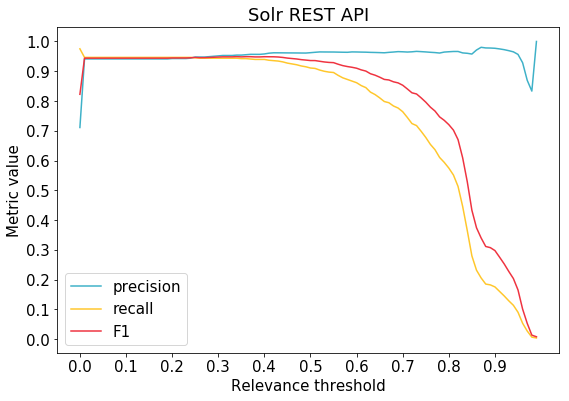

Maximum F1 (0.9490) is for threshold 0.34
Precision for this threshold: 0.9542
Recall for this threshold: 0.9438


In [5]:
plot_results(results_solr, 'Solr REST API')
print_best(results_solr)

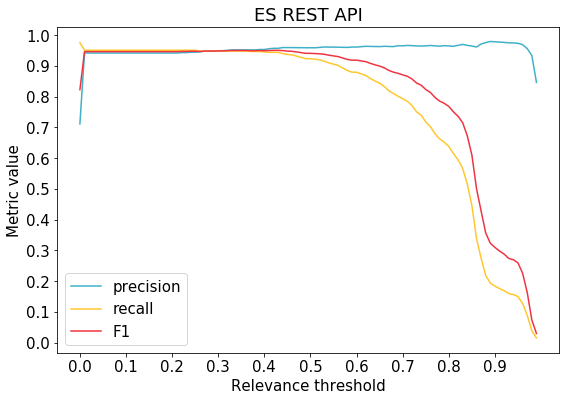

Maximum F1 (0.9503) is for threshold 0.43
Precision for this threshold: 0.9569
Recall for this threshold: 0.9438


In [6]:
plot_results(results_es, 'ES REST API')
print_best(results_es)

As the threshold increases, the matching becomes more cautious about what is returned. With large value of the threshold, the matcher has to be very sure of the candidate to return it. As the threshold increases, precision goes up and recall goes down. This is all expected.

We have two quite different best thresholds: 0.34 for Solr version (consistent with our current default) and 0.43 for ES version. At the same time, F1 line on both plots seems fairy flat for a wide range of threshold values. Let's look closer at the F1 values for different thresholds surrounding the best values:

In [7]:
pd.DataFrame([(i[0], i[1].get(dfk.EVAL_F1), j[1].get(dfk.EVAL_F1)) for i, j in zip(results_solr, results_es)],
             columns=['Score threshold', 'Solr F1', 'ES F1']).loc[30:50,]

Score threshold   Solr F1     ES F1
30             0.30  0.947658  0.948524
31             0.31  0.948312  0.948524
32             0.32  0.948312  0.949176
33             0.33  0.948312  0.949828
34             0.34  0.948966  0.949828
35             0.35  0.948240  0.949828
36             0.36  0.948895  0.949828
37             0.37  0.948824  0.949106
38             0.38  0.948097  0.949106
39             0.39  0.948097  0.949759
40             0.40  0.948753  0.949036
41             0.41  0.948611  0.949620
42             0.42  0.948540  0.950276
43             0.43  0.947808  0.950276
44             0.44  0.946341  0.949411
45             0.45  0.944134  0.947953
46             0.46  0.942657  0.947222
47             0.47  0.941176  0.945024
48             0.48  0.938947  0.942817
49             0.49  0.937456  0.940601
50             0.50  0.935870  0.940601

We can see here that for all threshold values between 0.30 and 0.44, ES version achieved very similar F1. This suggests that using the current threshold of 0.34 would still be good enough, and we will not have to upgrade the matching library in CS.

Here is the plot of the similarity scores from Solr-based matching vs. the scores from ES-based matching:

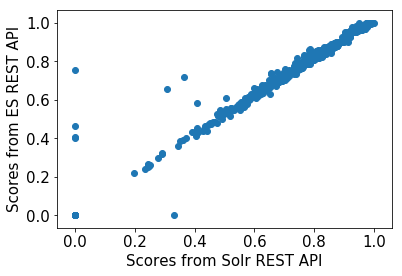

In [8]:
dataset_solr = read_validation_data('solr')
dataset_es = read_validation_data('es')
scores = [(i['score'], j['score']) for i, j in zip(dataset_solr, dataset_es)]
plt.scatter([d[0] for d in scores], [d[1] for d in scores])
plt.xlabel('Scores from Solr REST API')
plt.ylabel('Scores from ES REST API')
plt.show()

We have a very good correlation here apart from a few outliers. Here is the same plot, but only with those reference strings, for which the matched DOI is the same:

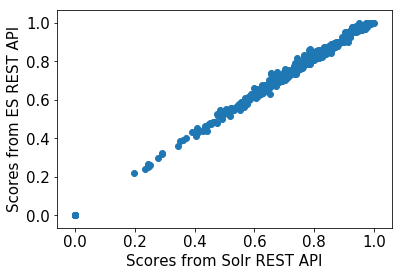

In [9]:
scores = [(i['score'], j['score']) for i, j in zip(dataset_solr, dataset_es) if i['target_test'] == j['target_test']]
plt.scatter([d[0] for d in scores], [d[1] for d in scores])
plt.xlabel('Scores from Solr REST API')
plt.ylabel('Scores from ES REST API')
plt.show()

All the outliers disappeared, meaning that they were precisely the cases where the matched DOI differs between the matchers.

This strong correlation between the scores further confirms it should safe to keep the current similarity threshold of 0.34.

## Performance estimation

We cannot use validation data for the estimation of the matcher's performance, because it was already used to choose the threshold, and therefore any estimate calculated on the validation data will be biased.

To estimate the performance, I will use a separate test dataset. It is very similar to the validation dataset. It contains 2000 reference strings, different from the validation data. Similarly as before, I have two versions of the test dataset, one with the results from Solr REST API, and the other one with the results from ES REST API.

In [10]:
def read_test_data(version):
    return read_json(DATA_DIR + 'test_' + version + '.json')[dfk.DATASET_DATASET]

dataset_solr = read_test_data('solr')
dataset_es = read_test_data('es')
len(dataset_solr)

2000

First, I apply the chosen threshold to the data:

In [11]:
dataset_solr = modify_by_threshold(dataset_solr, 0.34)
dataset_es = modify_by_threshold(dataset_es, 0.34)

Now let's see precision, recall and F1 on both test datasets:

In [12]:
results_solr = LinkMetricsResults(dataset_solr)
results_es = LinkMetricsResults(dataset_es)
pd.DataFrame([('Precision', results_solr.get(dfk.EVAL_PREC), results_es.get(dfk.EVAL_PREC)),
              ('Recall', results_solr.get(dfk.EVAL_REC), results_es.get(dfk.EVAL_REC)),
              ('F1', results_solr.get(dfk.EVAL_F1), results_es.get(dfk.EVAL_F1))],
             columns=['Metric', 'Solr version', 'ES version'])

Metric  Solr version  ES version
0  Precision      0.960616    0.959218
1     Recall      0.936561    0.942404
2         F1      0.948436    0.950737

ES version achieves slightly higher F1, with precision slightly lower and recall higher than Solr version. This further confirms that current threshold will still be good enough after migration.

Finally, let's see those references, for which the result differs between Solr and ES:

In [13]:
differences = [{'ref': i['ref_string'],
                'solr_DOI': i['target_test']['DOI'],
                'solr_score': i['score'],
                'es_DOI': j['target_test']['DOI'],
                'es_score': j['score'],
                'correct_DOI': i['target_gt']['DOI']}
               for i, j in zip(dataset_solr, dataset_es) if i['target_test'] != j['target_test']]
print(len(differences))
differences

35


[{'ref': 'Sain M, Law S, Suhara F, Boullioux A (2005) J. Reinf. Plast. Comp. 24(2):121',
  'solr_DOI': None,
  'solr_score': 0,
  'es_DOI': '10.1177/0731684405041717',
  'es_score': 0.7494627189473684,
  'correct_DOI': '10.1177/0731684405041717'},
 {'ref': 'W. Vogelsang, Nucl. Phys. B 475, 47 (1996)',
  'solr_DOI': '10.2307/591364',
  'solr_score': 0.6252360798639456,
  'es_DOI': '10.1016/0550-3213(96)00306-9',
  'es_score': 0.5838474222222223,
  'correct_DOI': '10.1016/0550-3213(96)00306-9'},
 {'ref': 'Golay J, Capucci A, Arsura M, Castellano M, Rizzo V, Introna M . 1991 Blood 77: 149–158',
  'solr_DOI': '10.1182/blood.v77.1.149.149',
  'solr_score': 0.8086144670977011,
  'es_DOI': '10.1182/blood.v77.1.149.bloodjournal771149',
  'es_score': 0.8729451811942398,
  'correct_DOI': '10.1182/blood.v77.1.149.149'},
 {'ref': 'S.A. Oke and A.E. Oluleye (2005). Tracking Distortions in Holistic Maintenance Measures: A Framework, J. of Ind. Eng. 16 (2005) 83-93.',
  'solr_DOI': None,
  'solr_scor

I inspected these cases manually and here is the breakdown:
- ES version is correct and Solr version is incorrect: 16
- Solr version is correct and ES version is incorrect: 11
- both versions are incorrect: 3
- matched DOIs are aliases: 5

## Conslusion

It should be safe to keep the current value of the threshold (0.34). The estimated performance for the matching using the new ES REST API is very slightly better than the performance of the matching using the current production Solr version, with the threshold of 0.34 (F1 0.9507 vs. 0.9484).